<a href="https://colab.research.google.com/github/Jessietbl/predictivemaintenance_ML_Project/blob/main/Predictive_Maintenance_TBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving predictive_maintenance.csv to predictive_maintenance.csv


In [ ]:
uploaded = files.upload()

Saving Predictive_Maintenance.zip to Predictive_Maintenance (1).zip


In [ ]:
import pandas as pd

In [ ]:
!unzip 'Predictive_Maintenance'


Archive:  Predictive_Maintenance.zip
   creating: Predictive_Maintenance/
  inflating: Predictive_Maintenance/datapreprocessing_sample1.py  
  inflating: Predictive_Maintenance/datapreprocessing_sample2.py  
  inflating: Predictive_Maintenance/datapreprocessing_sample3.py  
  inflating: Predictive_Maintenance/predictive_maintenance.csv  
  inflating: Predictive_Maintenance/predictive_maintenance_decisiontree.py  
  inflating: Predictive_Maintenance/predictive_maintenance_knn.py  
  inflating: Predictive_Maintenance/predictive_maintenance_lr.py  
  inflating: Predictive_Maintenance/predictive_maintenance_svmrbf.py  
  inflating: Predictive_Maintenance/test_decisiontree_sample1.py  
  inflating: Predictive_Maintenance/test_decisiontree_sample2.py  
  inflating: Predictive_Maintenance/test_decisiontree_sample3.py  
  inflating: Predictive_Maintenance/test_knn_sample1.py  
  inflating: Predictive_Maintenance/test_knn_sample2.py  
  inflating: Predictive_Maintenance/test_knn_sample3.py  
  

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Load Dataset
# Load the predictive maintenance dataset
data = pd.read_csv("/content/Predictive_Maintenance/predictive_maintenance.csv")
print("Initial dataset shape:", data.shape)

# Step 2: Handle Missing Values
# Separate numerical and categorical features
numerical_features = data.select_dtypes(include=np.number).columns
categorical_features = data.select_dtypes(exclude=np.number).columns

# Count missing values before imputation
missing_values_before = data.isnull().sum().sum()

# Impute missing values: Mean for numerical, Most Frequent for categorical
imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

data[numerical_features] = imputer_num.fit_transform(data[numerical_features])
data[categorical_features] = imputer_cat.fit_transform(data[categorical_features])

# Count missing values after imputation
missing_values_after = data.isnull().sum().sum()

# Calculate the number of missing values removed
missing_values_removed = missing_values_before - missing_values_after
print(f"Missing values handled successfully. Number of missing values removed: {missing_values_removed}")

# Step 3: Remove Outliers by Class
# Eliminate outliers using Z-score for each class
def remove_outliers_by_class(df, features, class_column, z_thresh=3):
    cleaned_data = []
    total_outliers = 0
    for class_label, group in df.groupby(class_column):
        z_scores = np.abs((group[features] - group[features].mean()) / group[features].std())
        group_outliers = (z_scores > z_thresh).any(axis=1)
        total_outliers += group_outliers.sum()
        cleaned_data.append(group[~group_outliers])
    return pd.concat(cleaned_data), total_outliers

data, total_outliers = remove_outliers_by_class(data, numerical_features, 'Failure Type', z_thresh=3)
print(f"Dataset shape after per-class outlier removal: {data.shape}")
print(f"Total number of outliers removed: {total_outliers}")

# Step 4: Remove Constant Features
# Drop features with only one unique value
constant_features = data.columns[data.nunique() == 1]
data.drop(columns=constant_features, inplace=True)
print(f"Constant features removed: {list(constant_features)}")

# Step 5: Discretize Continuous Features
# Use KBinsDiscretizer with uniform binning for continuous attributes
continuous_attributes = data.select_dtypes(include=['float64', 'int64']).columns
continuous_attributes = continuous_attributes.drop('Target', errors='ignore')  # Exclude 'Target' from discretization
for attribute in continuous_attributes:
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    data['Discretized_' + attribute] = discretizer.fit_transform(data[[attribute]])
print("Discretization completed using uniform binning.")

# Step 6: Drop Irrelevant Features
# Remove irrelevant features (e.g., UDI, Product ID, Target)
data_cleaned = data.drop(columns=['UDI', 'Product ID', 'Target'], errors='ignore')

# Step 7: Encode Categorical Variables
# Encode 'Type' and 'Failure Type' with special handling for custom class order
label_encoders = {}
for column in ['Type', 'Failure Type']:
    le = LabelEncoder()
    if column == 'Failure Type':
        sorted_classes = sorted(data_cleaned[column].unique(), key=lambda x: (x != "No Failure", x))
        le.classes_ = np.array(sorted_classes)
        data_cleaned[column] = le.transform(data_cleaned[column])
    else:
        data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

# Display Failure Type encoding
print("Failure Type Encoding:")
for original, encoded in zip(label_encoders['Failure Type'].classes_, range(len(label_encoders['Failure Type'].classes_))):
    print(f"{original}: {encoded}")

# Save Label Encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
joblib.dump(label_encoders, label_encoders_filename)
print(f"Label encoders saved: {label_encoders_filename}")

# Step 8: Separate Features and Target
# Split dataset into features (X) and target (y)
X = data_cleaned.drop(columns=['Failure Type'])
y = data_cleaned['Failure Type']

# Step 9: Scale Numerical Features
# Apply StandardScaler to numerical columns
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 10: Apply SMOTE for Class Balancing
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE applied. Balanced Data: {X_train_smote.shape}, {y_train_smote.shape}")

# Step 11: Sample 10 Instances Proportionally
# Sample 10 instances based on class distribution
total_samples = 10
class_counts = y.value_counts()
class_proportions = class_counts / class_counts.sum()
initial_allocation = pd.Series(1, index=class_counts.index)
remaining_samples = total_samples - initial_allocation.sum()
additional_samples = (class_proportions * remaining_samples).round().astype(int)
final_allocation = initial_allocation + additional_samples

# Adjust for exact sample count
adjustment = total_samples - final_allocation.sum()
if adjustment > 0:
    for class_label in final_allocation.nlargest(adjustment).index:
        final_allocation[class_label] += 1
elif adjustment < 0:
    for class_label in final_allocation.nsmallest(-adjustment).index:
        final_allocation[class_label] -= 1

sampled_data = pd.concat(
    [
        pd.concat([X, y], axis=1)
        .loc[pd.concat([X, y], axis=1)['Failure Type'] == class_label]
        .sample(n=samples, replace=True, random_state=42)
        for class_label, samples in final_allocation.items()
    ]
).reset_index(drop=True)

# Step 12: Save Processed Data
# Save training, target, and sampled data
X_train_smote.to_csv('/content/Predictive_Maintenance/X_training_smote.csv', index=False)
y_train_smote.to_csv('/content/Predictive_Maintenance/y_training_smote.csv', index=False)
sampled_data.to_csv("/content/Predictive_Maintenance/sample1.csv", index=False)

# Step 13: Display Required Information
# Display preprocessing completion details
print("Data preprocessing complete. Files saved.")
print(y.value_counts())
print("Unique classes in sampled data:", sampled_data['Failure Type'].nunique())


Initial dataset shape: (10000, 10)
Missing values handled successfully. Number of missing values removed: 0
Dataset shape after per-class outlier removal: (9832, 10)
Total number of outliers removed: 168
Constant features removed: []
Discretization completed using uniform binning.
Failure Type Encoding:
No Failure: 0
Heat Dissipation Failure: 1
Overstrain Failure: 2
Power Failure: 3
Random Failures: 4
Tool Wear Failure: 5
Label encoders saved: /content/Predictive_Maintenance/label_encoders.joblib
SMOTE applied. Balanced Data: (45612, 12), (45612,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Data preprocessing complete. Files saved.
Failure Type
0    9488
1     109
3      95
2      78
5      44
4      18
Name: count, dtype: int64
Unique classes in sampled data: 6


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Load Dataset
# Load the predictive maintenance dataset
data = pd.read_csv("/content/Predictive_Maintenance/predictive_maintenance.csv")
print("Initial dataset shape:", data.shape)

# Step 2: Handle Missing Values
# Separate numerical and categorical features
numerical_features = data.select_dtypes(include=np.number).columns
categorical_features = data.select_dtypes(exclude=np.number).columns

# Impute missing values: Mean for numerical, Most Frequent for categorical
imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

data[numerical_features] = imputer_num.fit_transform(data[numerical_features])
data[categorical_features] = imputer_cat.fit_transform(data[categorical_features])
print("Missing values handled successfully.")

# Step 3: Remove Outliers by Class
# Eliminate outliers using Z-score for each class
def remove_outliers_by_class(df, features, class_column, z_thresh=3):
    cleaned_data = []
    for class_label, group in df.groupby(class_column):
        z_scores = np.abs((group[features] - group[features].mean()) / group[features].std())
        group_outliers = (z_scores > z_thresh).any(axis=1)
        cleaned_data.append(group[~group_outliers])
    return pd.concat(cleaned_data)

data = remove_outliers_by_class(data, numerical_features, 'Failure Type', z_thresh=3)
print(f"Dataset shape after per-class outlier removal: {data.shape}")

# Step 4: Remove Constant Features
# Drop features with only one unique value
constant_features = data.columns[data.nunique() == 1]
data.drop(columns=constant_features, inplace=True)
print(f"Constant features removed: {list(constant_features)}")

# Step 5: Discretize Continuous Features
# Use KBinsDiscretizer with uniform binning for continuous attributes
continuous_attributes = data.select_dtypes(include=['float64', 'int64']).columns
continuous_attributes = continuous_attributes.drop('Target', errors='ignore')  # Exclude 'Target' from discretization
for attribute in continuous_attributes:
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    data['Discretized_' + attribute] = discretizer.fit_transform(data[[attribute]])
print("Discretization completed using uniform binning.")

# Step 6: Drop Irrelevant Features
# Remove irrelevant features (e.g., UDI, Product ID, Target)
data_cleaned = data.drop(columns=['UDI', 'Product ID', 'Target'], errors='ignore')

# Step 7: Encode Categorical Variables
# Encode 'Type' and 'Failure Type' with special handling for custom class order
label_encoders = {}
for column in ['Type', 'Failure Type']:
    le = LabelEncoder()
    if column == 'Failure Type':
        sorted_classes = sorted(data_cleaned[column].unique(), key=lambda x: (x != "No Failure", x))
        le.classes_ = np.array(sorted_classes)
        data_cleaned[column] = le.transform(data_cleaned[column])
    else:
        data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

# Display Failure Type encoding
print("Failure Type Encoding:")
for original, encoded in zip(label_encoders['Failure Type'].classes_, range(len(label_encoders['Failure Type'].classes_))):
    print(f"{original}: {encoded}")

# Save Label Encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
joblib.dump(label_encoders, label_encoders_filename)
print(f"Label encoders saved: {label_encoders_filename}")

# Step 8: Separate Features and Target
# Split dataset into features (X) and target (y)
X = data_cleaned.drop(columns=['Failure Type'])
y = data_cleaned['Failure Type']

# Step 9: Scale Numerical Features
# Apply StandardScaler to numerical columns
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 10: Apply SMOTE for Class Balancing
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE applied. Balanced Data: {X_train_smote.shape}, {y_train_smote.shape}")

# Step 11: Sample 10 Instances (2 per failure type excluding "No Failure")
# Exclude "No Failure" (encoded as 0)
failure_types = y_train_smote.unique()
failure_types = failure_types[failure_types != 0]  # Exclude "No Failure"

# Create an empty list to store sampled data
sampled_data_list = []

# For each failure type, sample 2 instances
for failure_type in failure_types:
    sampled_data_list.append(
        pd.concat([X_train_smote, y_train_smote], axis=1)
        .loc[pd.concat([X_train_smote, y_train_smote], axis=1)['Failure Type'] == failure_type]
        .sample(n=2, replace=True, random_state=42)
    )

# Combine all sampled data into a single DataFrame
sampled_data = pd.concat(sampled_data_list).reset_index(drop=True)

# Step 12: Save Processed Data
# Save training, target, and sampled data
X_train_smote.to_csv('/content/Predictive_Maintenance/X_training_smote.csv', index=False)
y_train_smote.to_csv('/content/Predictive_Maintenance/y_training_smote.csv', index=False)
sampled_data.to_csv("/content/Predictive_Maintenance/sample2.csv", index=False)

# Step 13: Display Required Information
# Display preprocessing completion details
print("Data preprocessing complete. Files saved.")
print(y.value_counts())
print("Unique classes in sampled data:", sampled_data['Failure Type'].nunique())


Initial dataset shape: (10000, 10)
Missing values handled successfully.
Dataset shape after per-class outlier removal: (9832, 10)
Constant features removed: []
Discretization completed using uniform binning.
Failure Type Encoding:
No Failure: 0
Heat Dissipation Failure: 1
Overstrain Failure: 2
Power Failure: 3
Random Failures: 4
Tool Wear Failure: 5
Label encoders saved: /content/Predictive_Maintenance/label_encoders.joblib


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


SMOTE applied. Balanced Data: (45612, 12), (45612,)
Data preprocessing complete. Files saved.
Failure Type
0    9488
1     109
3      95
2      78
5      44
4      18
Name: count, dtype: int64
Unique classes in sampled data: 5


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Load Dataset
# Load the predictive maintenance dataset
data = pd.read_csv("/content/Predictive_Maintenance/predictive_maintenance.csv")
print("Initial dataset shape:", data.shape)

# Step 2: Handle Missing Values
# Separate numerical and categorical features
numerical_features = data.select_dtypes(include=np.number).columns
categorical_features = data.select_dtypes(exclude=np.number).columns

# Impute missing values: Mean for numerical, Most Frequent for categorical
imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

data[numerical_features] = imputer_num.fit_transform(data[numerical_features])
data[categorical_features] = imputer_cat.fit_transform(data[categorical_features])
print("Missing values handled successfully.")

# Step 3: Remove Outliers by Class
# Eliminate outliers using Z-score for each class
def remove_outliers_by_class(df, features, class_column, z_thresh=3):
    cleaned_data = []
    for class_label, group in df.groupby(class_column):
        z_scores = np.abs((group[features] - group[features].mean()) / group[features].std())
        group_outliers = (z_scores > z_thresh).any(axis=1)
        cleaned_data.append(group[~group_outliers])
    return pd.concat(cleaned_data)

data = remove_outliers_by_class(data, numerical_features, 'Failure Type', z_thresh=3)
print(f"Dataset shape after per-class outlier removal: {data.shape}")

# Step 4: Remove Constant Features
# Drop features with only one unique value
constant_features = data.columns[data.nunique() == 1]
data.drop(columns=constant_features, inplace=True)
print(f"Constant features removed: {list(constant_features)}")

# Step 5: Discretize Continuous Features
# Use KBinsDiscretizer with uniform binning for continuous attributes
continuous_attributes = data.select_dtypes(include=['float64', 'int64']).columns
continuous_attributes = continuous_attributes.drop('Target', errors='ignore')  # Exclude 'Target' from discretization
for attribute in continuous_attributes:
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    data['Discretized_' + attribute] = discretizer.fit_transform(data[[attribute]])
print("Discretization completed using uniform binning.")

# Step 6: Drop Irrelevant Features
# Remove irrelevant features (e.g., UDI, Product ID, Target)
data_cleaned = data.drop(columns=['UDI', 'Product ID', 'Target'], errors='ignore')

# Step 7: Encode Categorical Variables
# Encode 'Type' and 'Failure Type' with special handling for custom class order
label_encoders = {}
for column in ['Type', 'Failure Type']:
    le = LabelEncoder()
    if column == 'Failure Type':
        sorted_classes = sorted(data_cleaned[column].unique(), key=lambda x: (x != "No Failure", x))
        le.classes_ = np.array(sorted_classes)
        data_cleaned[column] = le.transform(data_cleaned[column])
    else:
        data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

# Display Failure Type encoding
print("Failure Type Encoding:")
for original, encoded in zip(label_encoders['Failure Type'].classes_, range(len(label_encoders['Failure Type'].classes_))):
    print(f"{original}: {encoded}")

# Save Label Encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
joblib.dump(label_encoders, label_encoders_filename)
print(f"Label encoders saved: {label_encoders_filename}")

# Step 8: Separate Features and Target
# Split dataset into features (X) and target (y)
X = data_cleaned.drop(columns=['Failure Type'])
y = data_cleaned['Failure Type']

# Step 9: Scale Numerical Features
# Apply StandardScaler to numerical columns
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 10: Apply SMOTE for Class Balancing
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"SMOTE applied. Balanced Data: {X_train_smote.shape}, {y_train_smote.shape}")

# Step 11: Sample 10 Instances from "No Failure" (encoded as 0)
# Filter the dataset to include only "No Failure" rows
no_failure_data = pd.concat([X, y], axis=1).loc[y == 0]

# Sample 10 instances from the "No Failure" class
sampled_data = no_failure_data.sample(n=10, replace=True, random_state=42).reset_index(drop=True)

# Step 12: Save Processed Data
# Save training, target, and sampled data
X_train_smote.to_csv('/content/Predictive_Maintenance/X_training_smote.csv', index=False)
y_train_smote.to_csv('/content/Predictive_Maintenance/y_training_smote.csv', index=False)
sampled_data.to_csv("/content/Predictive_Maintenance/sample3.csv", index=False)

# Step 13: Display Required Information
# Display preprocessing completion details
print("Data preprocessing complete. Files saved.")
print(y.value_counts())
print("Unique classes in sampled data:", sampled_data['Failure Type'].nunique())


Initial dataset shape: (10000, 10)
Missing values handled successfully.
Dataset shape after per-class outlier removal: (9832, 10)
Constant features removed: []
Discretization completed using uniform binning.
Failure Type Encoding:
No Failure: 0
Heat Dissipation Failure: 1
Overstrain Failure: 2
Power Failure: 3
Random Failures: 4
Tool Wear Failure: 5
Label encoders saved: /content/Predictive_Maintenance/label_encoders.joblib
SMOTE applied. Balanced Data: (45612, 12), (45612,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Data preprocessing complete. Files saved.
Failure Type
0    9488
1     109
3      95
2      78
5      44
4      18
Name: count, dtype: int64
Unique classes in sampled data: 1


Cross-validation for Logistic Regression: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


Logistic Regression: Mean Accuracy = 0.9005, Std = 0.0035
Class 0: Precision = 0.7524, Recall = 0.6616, F1-Score = 0.7041, Support = 604
Class 1: Precision = 0.9760, Recall = 0.9920, F1-Score = 0.9839, Support = 613
Class 2: Precision = 0.9607, Recall = 0.9949, F1-Score = 0.9775, Support = 612
Class 3: Precision = 0.9949, Recall = 0.9941, F1-Score = 0.9945, Support = 611
Class 4: Precision = 0.7595, Recall = 0.7744, F1-Score = 0.7668, Support = 604
Class 5: Precision = 0.9361, Recall = 0.9817, F1-Score = 0.9583, Support = 606
Model saved: /content/Predictive_Maintenance/logisticregression_model.joblib


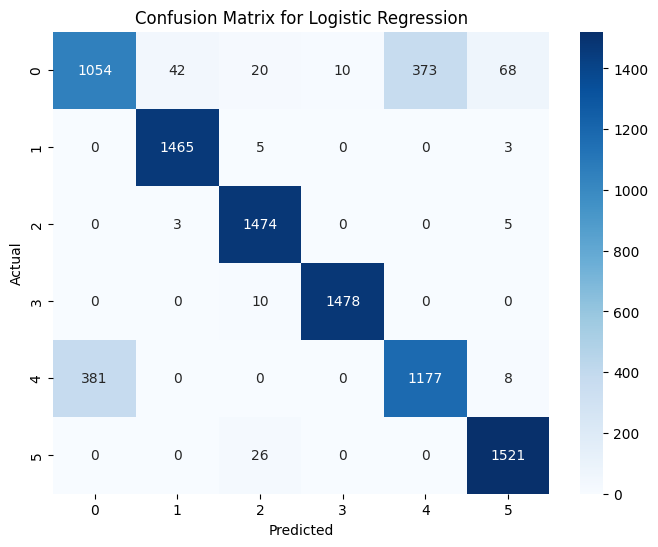

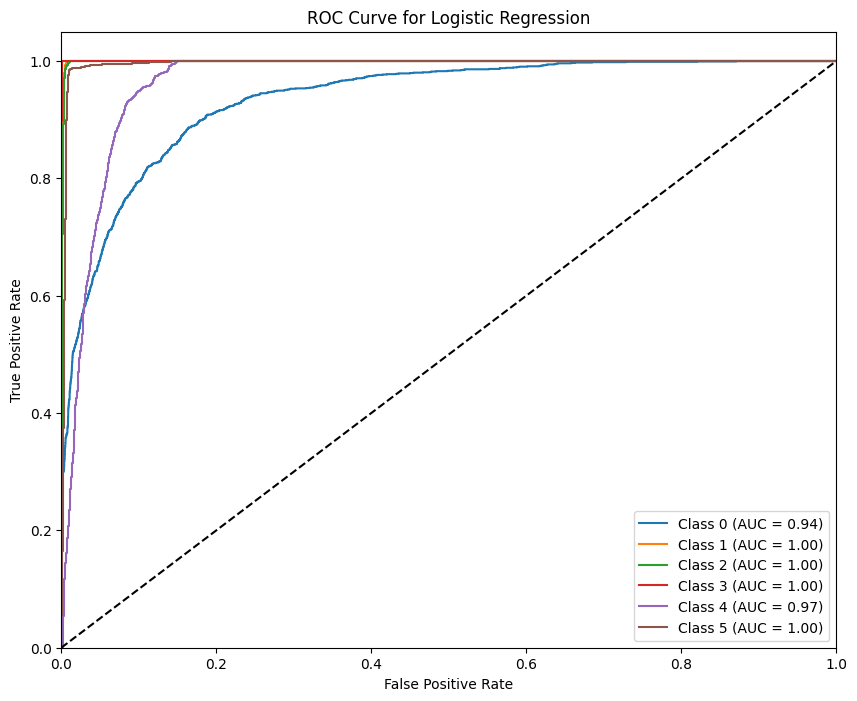

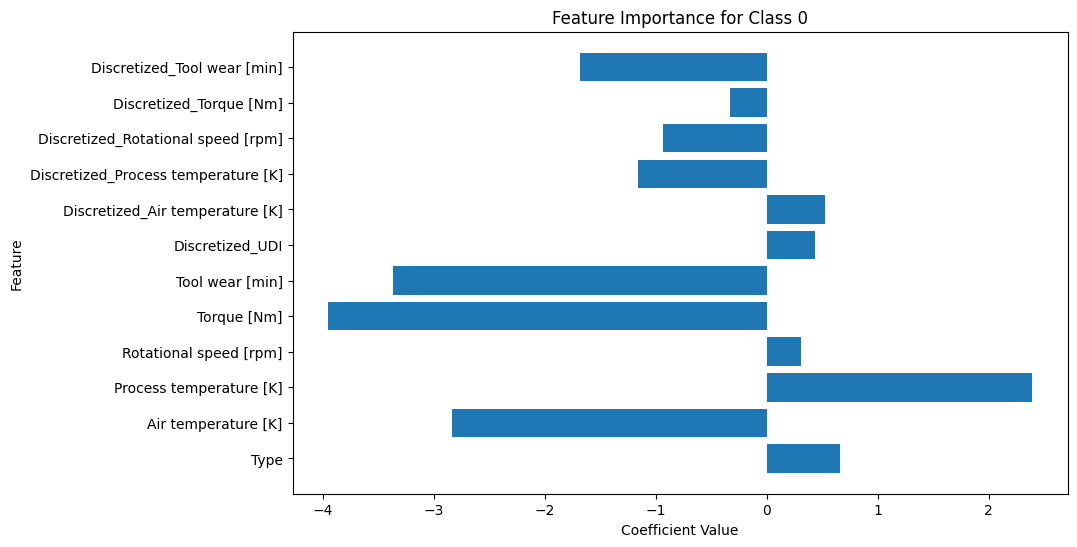

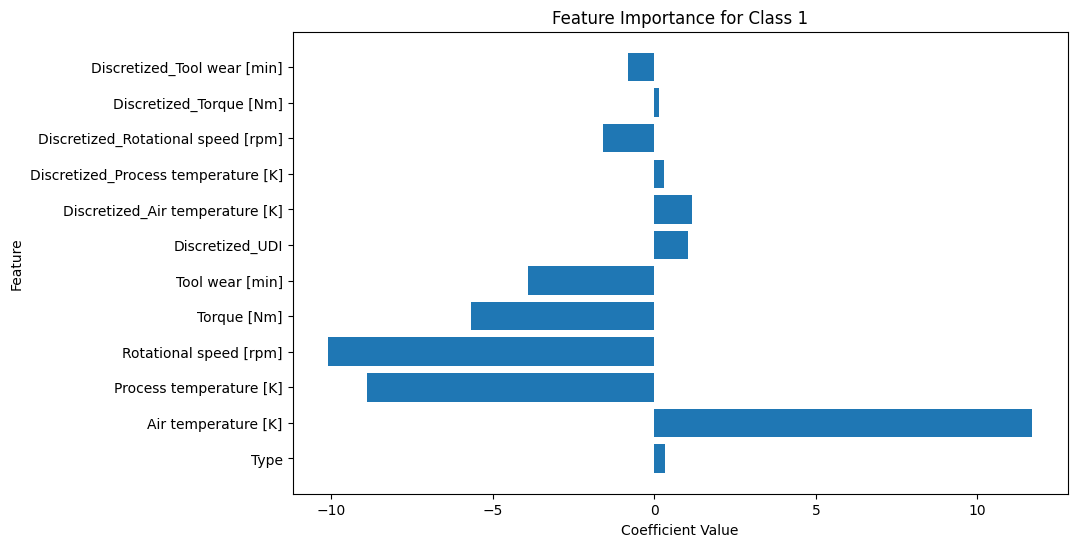

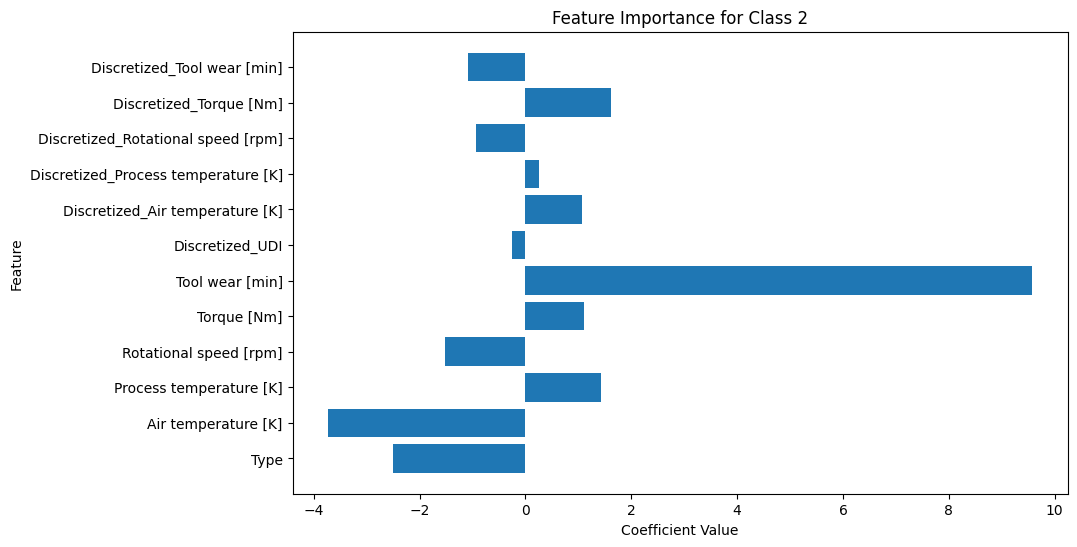

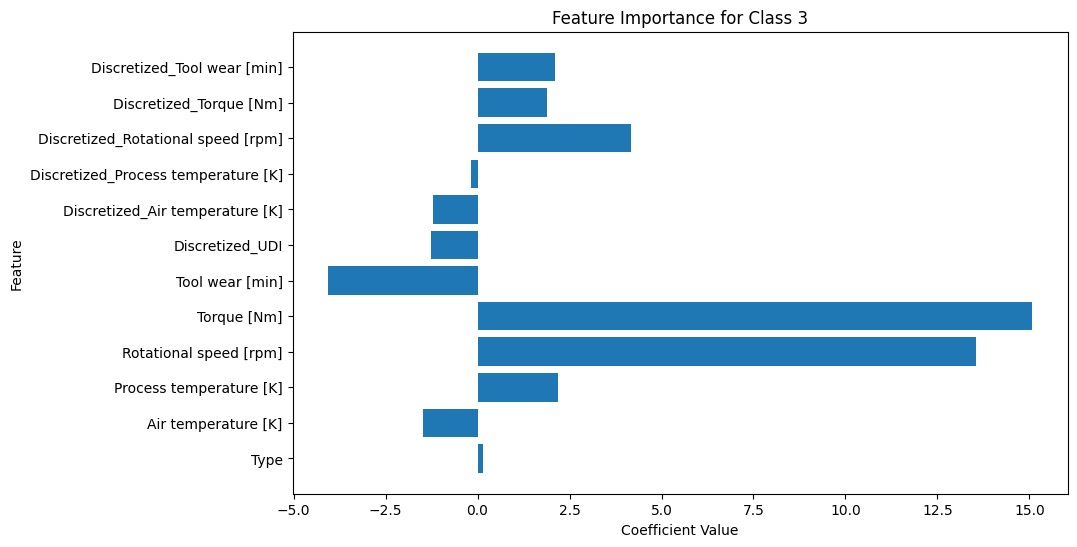

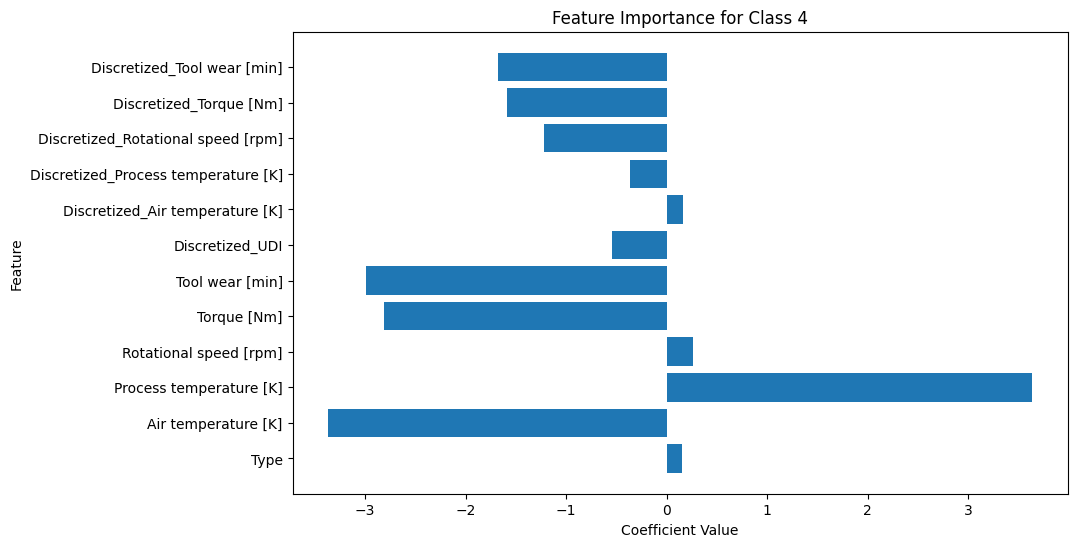

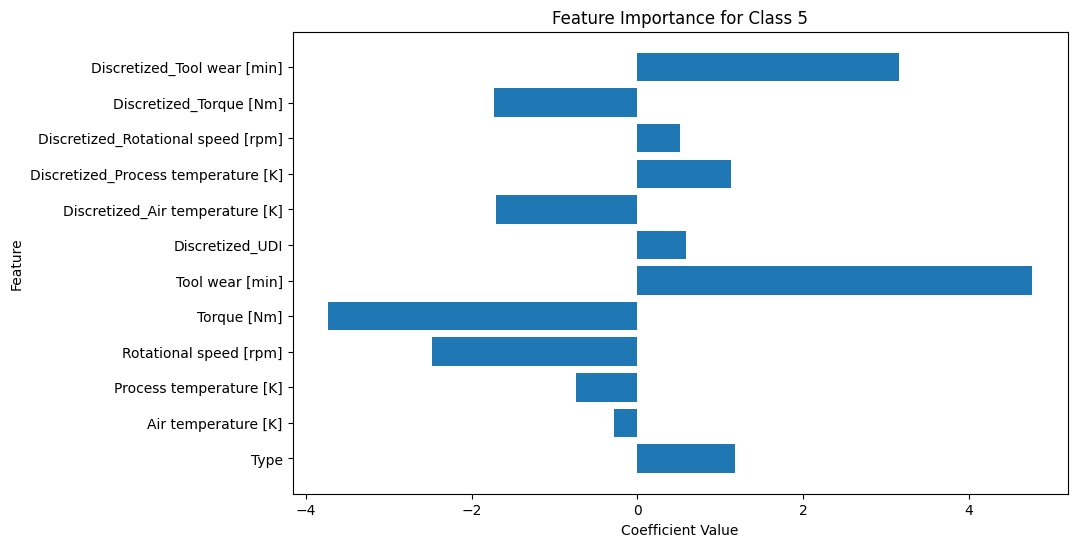

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load data
X_train = pd.read_csv('/content/Predictive_Maintenance/X_training_smote.csv')
y_train = pd.read_csv('/content/Predictive_Maintenance/y_training_smote.csv')

# Combine train features and target
X_train_combined = X_train
y_train_combined = y_train.values.ravel()  # Reshape y_train_combined here

# Split dataset into train and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_train_combined, y_train_combined, test_size=0.2, random_state=42
)

# Define Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []
precision_scores = []
recall_scores = []
f1_scores = []
support_scores = []

for train_index, test_index in tqdm(cv.split(X_train_combined, y_train_combined),
                                     desc="Cross-validation for Logistic Regression",
                                     total=cv.get_n_splits()):
    X_train, X_test = X_train_combined.iloc[train_index], X_train_combined.iloc[test_index]
    y_train, y_test = y_train_combined[train_index], y_train_combined[test_index]

    # Train the model
    logistic_regression.fit(X_train, y_train)

    # Evaluate the model
    y_pred = logistic_regression.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    support_scores.append(support)

# Calculate mean and standard deviation of accuracy
mean_acc = np.mean(scores)
std_acc = np.std(scores)

# Calculate mean precision, recall, f1-score, and support for each class
mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)
mean_support = np.mean(support_scores, axis=0)

print(f"Logistic Regression: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")
for i, class_label in enumerate(np.unique(y_train_combined)):
    print(f"Class {class_label}: Precision = {mean_precision[i]:.4f}, Recall = {mean_recall[i]:.4f}, F1-Score = {mean_f1[i]:.4f}, Support = {mean_support[i]:.0f}")

# Train final Logistic Regression model on the entire training set
logistic_regression.fit(X_train_combined, y_train_combined)
y_pred = logistic_regression.predict(X_test_combined)
y_prob = logistic_regression.predict_proba(X_test_combined)

# Save the Logistic Regression model using joblib
model_filename = '/content/Predictive_Maintenance/logisticregression_model.joblib'
joblib.dump(logistic_regression, model_filename)
print(f"Model saved: {model_filename}")

# Confusion Matrix
cm = confusion_matrix(y_test_combined, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    fpr, tpr, _ = roc_curve(y_test_combined == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Feature Importance (coefficients)
coefficients = logistic_regression.coef_
feature_names = X_train_combined.columns
for i in range(len(coefficients)):
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients[i])
    plt.title(f'Feature Importance for Class {i}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()


Cross-validation for KNN: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


KNN: Mean Accuracy = 0.9881, Std = 0.0014
Class 0: Precision = 1.0000, Recall = 0.9281, F1-Score = 0.9627, Support = 604
Class 1: Precision = 0.9800, Recall = 1.0000, F1-Score = 0.9899, Support = 613
Class 2: Precision = 0.9895, Recall = 1.0000, F1-Score = 0.9947, Support = 612
Class 3: Precision = 0.9932, Recall = 1.0000, F1-Score = 0.9966, Support = 611
Class 4: Precision = 0.9842, Recall = 1.0000, F1-Score = 0.9920, Support = 604
Class 5: Precision = 0.9830, Recall = 1.0000, F1-Score = 0.9914, Support = 606
Model saved: /content/Predictive_Maintenance/knn_model.joblib


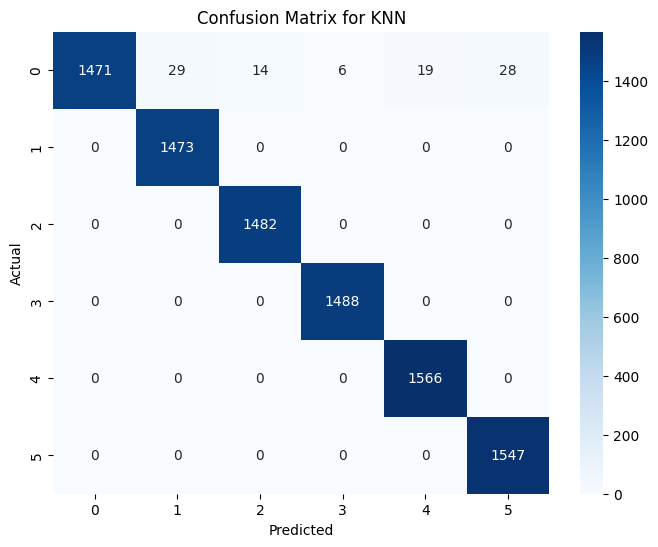

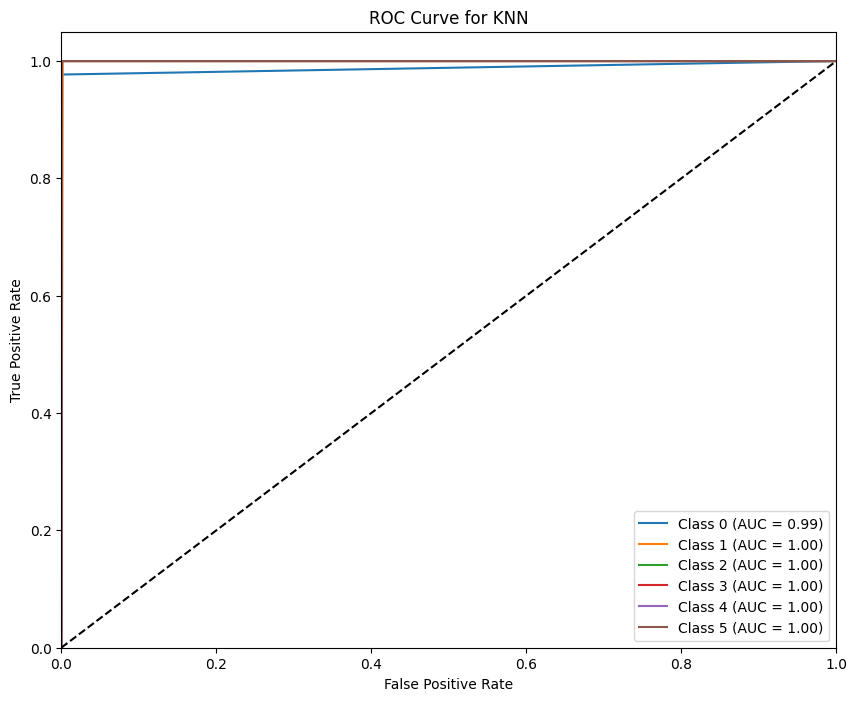

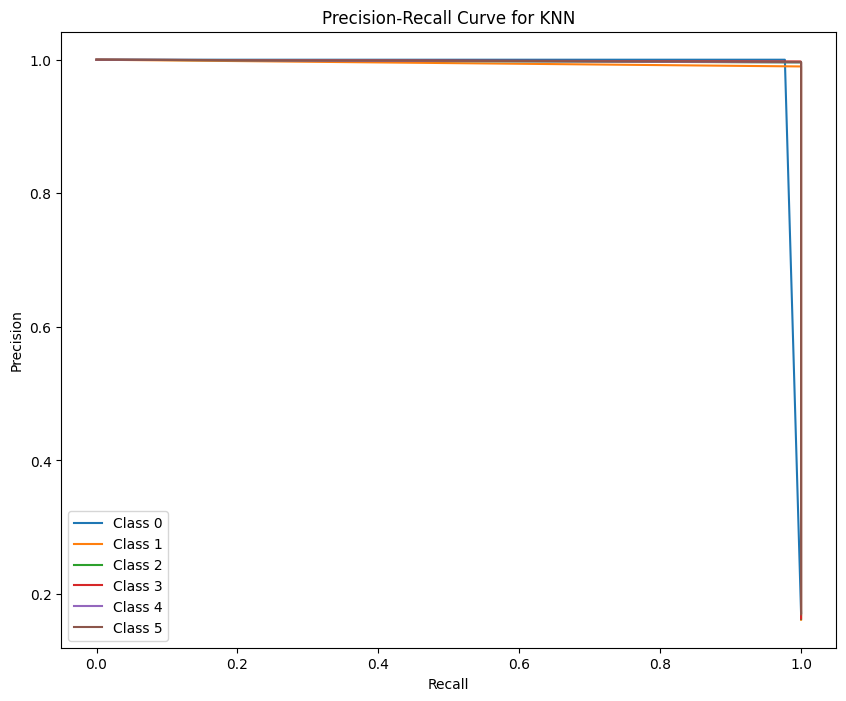

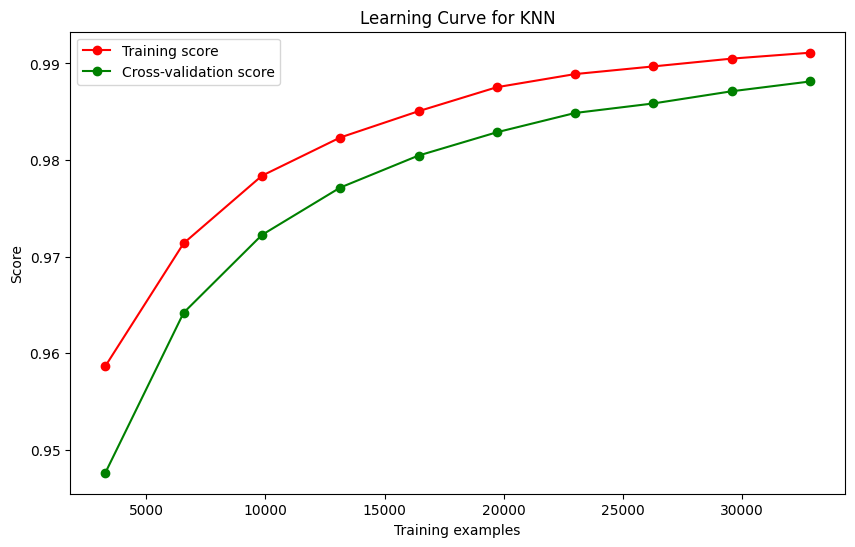

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load data
X_train = pd.read_csv('/content/Predictive_Maintenance/X_training_smote.csv')
y_train = pd.read_csv('/content/Predictive_Maintenance/y_training_smote.csv')

# Combine train features and target
X_train_combined = X_train
y_train_combined = y_train.values.ravel()  # Reshape y_train_combined here

# Split dataset into train and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_train_combined, y_train_combined, test_size=0.2, random_state=42
)

# Define K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier()

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []
precision_scores = []
recall_scores = []
f1_scores = []
support_scores = []

for train_index, test_index in tqdm(cv.split(X_train_combined, y_train_combined),
                                     desc="Cross-validation for KNN",
                                     total=cv.get_n_splits()):
    X_train, X_test = X_train_combined.iloc[train_index], X_train_combined.iloc[test_index]
    y_train, y_test = y_train_combined[train_index], y_train_combined[test_index]

    # Train the model
    knn.fit(X_train, y_train)

    # Evaluate the model
    y_pred = knn.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    support_scores.append(support)

# Calculate mean and standard deviation of accuracy
mean_acc = np.mean(scores)
std_acc = np.std(scores)

# Calculate mean precision, recall, f1-score, and support for each class
mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)
mean_support = np.mean(support_scores, axis=0)

print(f"KNN: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")
for i, class_label in enumerate(np.unique(y_train_combined)):
    print(f"Class {class_label}: Precision = {mean_precision[i]:.4f}, Recall = {mean_recall[i]:.4f}, F1-Score = {mean_f1[i]:.4f}, Support = {mean_support[i]:.0f}")

# Train final KNN model on the entire training set
knn.fit(X_train_combined, y_train_combined)
y_pred = knn.predict(X_test_combined)
y_prob = knn.predict_proba(X_test_combined)

# Save the KNN model using joblib
model_filename = '/content/Predictive_Maintenance/knn_model.joblib'
joblib.dump(knn, model_filename)
print(f"Model saved: {model_filename}")

# Confusion Matrix
cm = confusion_matrix(y_test_combined, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    fpr, tpr, _ = roc_curve(y_test_combined == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    precision, recall, _ = precision_recall_curve(y_test_combined == i, y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNN')
plt.legend(loc='lower left')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(knn, X_train_combined, y_train_combined, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve for KNN')
plt.legend(loc="best")
plt.show()


Cross-validation for SVM: 100%|██████████| 10/10 [07:40<00:00, 46.03s/it]


SVM: Mean Accuracy = 0.9792, Std = 0.0013
Class 0: Precision = 1.0000, Recall = 0.8741, F1-Score = 0.9328, Support = 604
Class 1: Precision = 0.9823, Recall = 1.0000, F1-Score = 0.9910, Support = 613
Class 2: Precision = 0.9929, Recall = 1.0000, F1-Score = 0.9964, Support = 612
Class 3: Precision = 0.9964, Recall = 1.0000, F1-Score = 0.9982, Support = 611
Class 4: Precision = 0.9492, Recall = 1.0000, F1-Score = 0.9740, Support = 604
Class 5: Precision = 0.9589, Recall = 1.0000, F1-Score = 0.9790, Support = 606
Model saved: /content/Predictive_Maintenance/svm_rbf_model.joblib
Feature names saved: /content/Predictive_Maintenance/feature_names.joblib


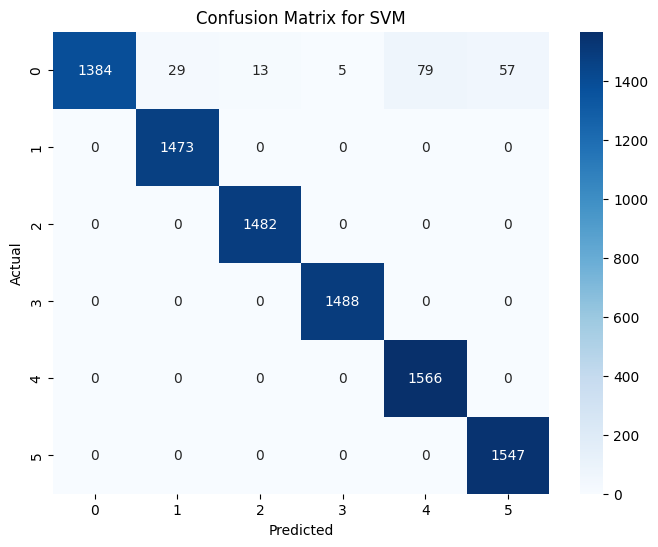

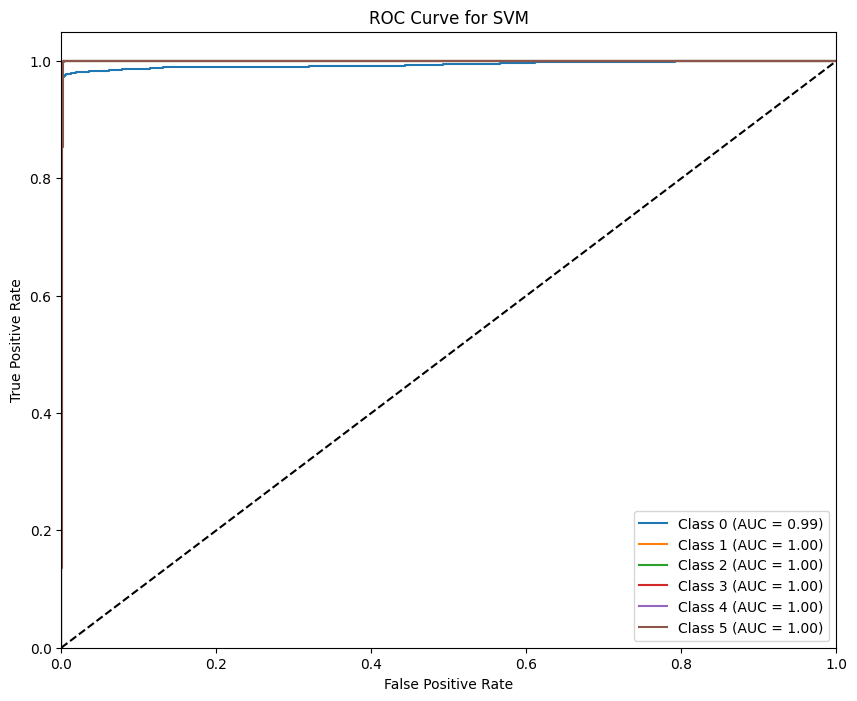

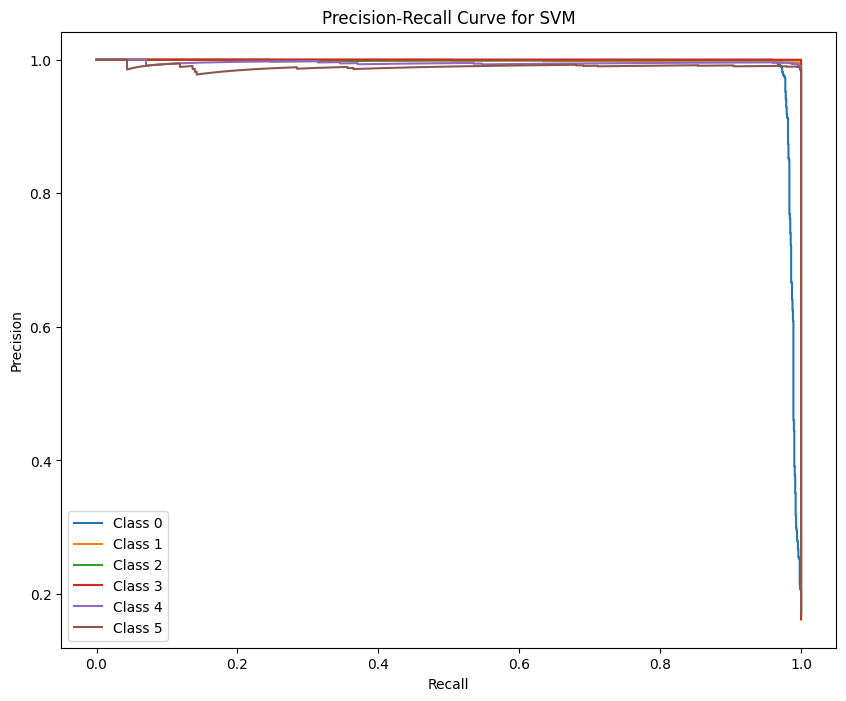

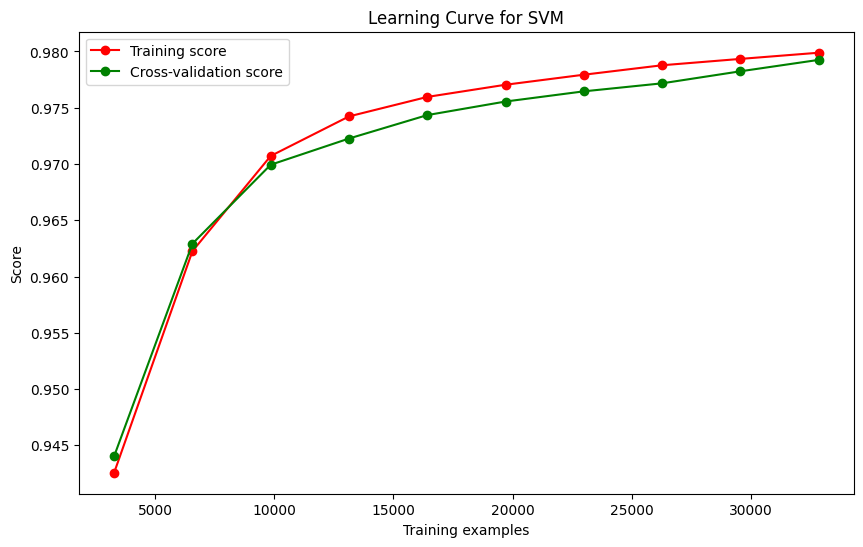

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

# Load data
X_train = pd.read_csv('/content/Predictive_Maintenance/X_training_smote.csv')
y_train = pd.read_csv('/content/Predictive_Maintenance/y_training_smote.csv')

# Combine train features and target
X_train_combined = X_train
y_train_combined = y_train.values.ravel()  # Reshape y_train_combined here

# Split dataset into train and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_train_combined, y_train_combined, test_size=0.2, random_state=42
)

# Define SVM with RBF kernel model
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []
precision_scores = []
recall_scores = []
f1_scores = []
support_scores = []

for train_index, test_index in tqdm(cv.split(X_train_combined, y_train_combined),
                                     desc="Cross-validation for SVM",
                                     total=cv.get_n_splits()):
    X_train, X_test = X_train_combined.iloc[train_index], X_train_combined.iloc[test_index]
    y_train, y_test = y_train_combined[train_index], y_train_combined[test_index]

    # Train the model
    svm_rbf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = svm_rbf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    support_scores.append(support)

# Calculate mean and standard deviation of accuracy
mean_acc = np.mean(scores)
std_acc = np.std(scores)

# Calculate mean precision, recall, f1-score, and support for each class
mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)
mean_support = np.mean(support_scores, axis=0)

print(f"SVM: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")
for i, class_label in enumerate(np.unique(y_train_combined)):
    print(f"Class {class_label}: Precision = {mean_precision[i]:.4f}, Recall = {mean_recall[i]:.4f}, F1-Score = {mean_f1[i]:.4f}, Support = {mean_support[i]:.0f}")

# Train final SVM model on the entire training set
svm_rbf.fit(X_train_combined, y_train_combined)
y_pred = svm_rbf.predict(X_test_combined)
y_prob = svm_rbf.predict_proba(X_test_combined)

# Save the SVM model using joblib
model_filename = '/content/Predictive_Maintenance/svm_rbf_model.joblib'
joblib.dump(svm_rbf, model_filename)
print(f"Model saved: {model_filename}")

# Save the feature names
feature_names_filename = '/content/Predictive_Maintenance/feature_names.joblib'
joblib.dump(X_train_combined.columns.tolist(), feature_names_filename)
print(f"Feature names saved: {feature_names_filename}")

# Confusion Matrix
cm = confusion_matrix(y_test_combined, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    fpr, tpr, _ = roc_curve(y_test_combined == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    precision, recall, _ = precision_recall_curve(y_test_combined == i, y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM')
plt.legend(loc='lower left')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(svm_rbf, X_train_combined, y_train_combined, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve for SVM')
plt.legend(loc="best")
plt.show()


Cross-validation for Decision Tree: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Decision Tree: Mean Accuracy = 0.9944, Std = 0.0012
Class 0: Precision = 0.9890, Recall = 0.9806, F1-Score = 0.9848, Support = 604
Class 1: Precision = 0.9979, Recall = 0.9982, F1-Score = 0.9980, Support = 613
Class 2: Precision = 0.9961, Recall = 0.9979, F1-Score = 0.9970, Support = 612
Class 3: Precision = 0.9972, Recall = 0.9982, F1-Score = 0.9977, Support = 611
Class 4: Precision = 0.9947, Recall = 0.9962, F1-Score = 0.9954, Support = 604
Class 5: Precision = 0.9915, Recall = 0.9952, F1-Score = 0.9933, Support = 606
Model saved: /content/Predictive_Maintenance/decisiontree_model.joblib


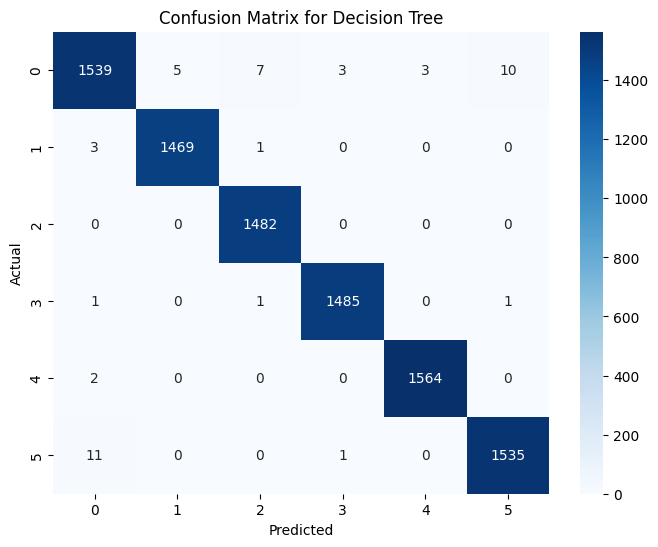

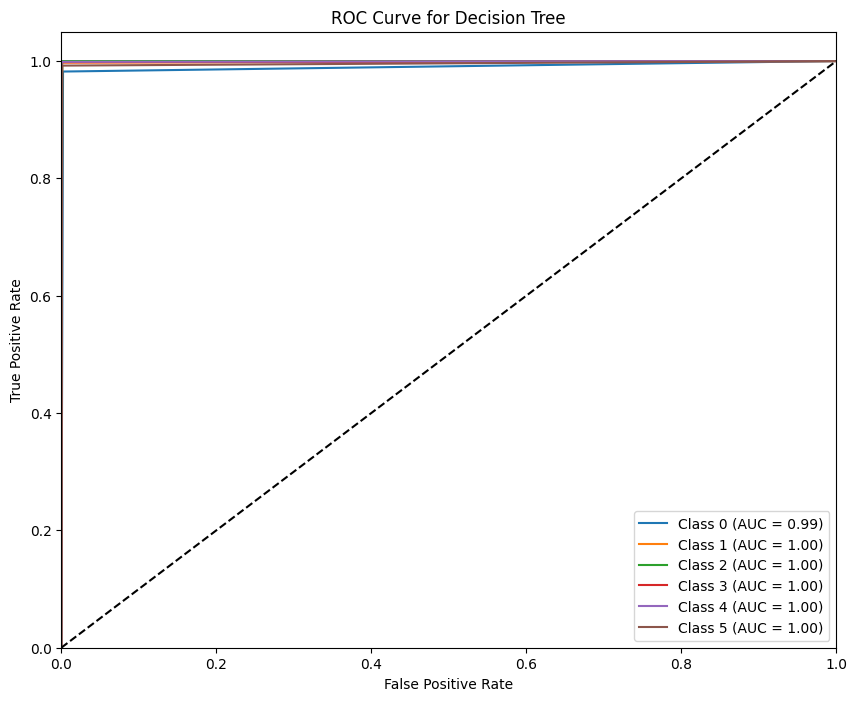

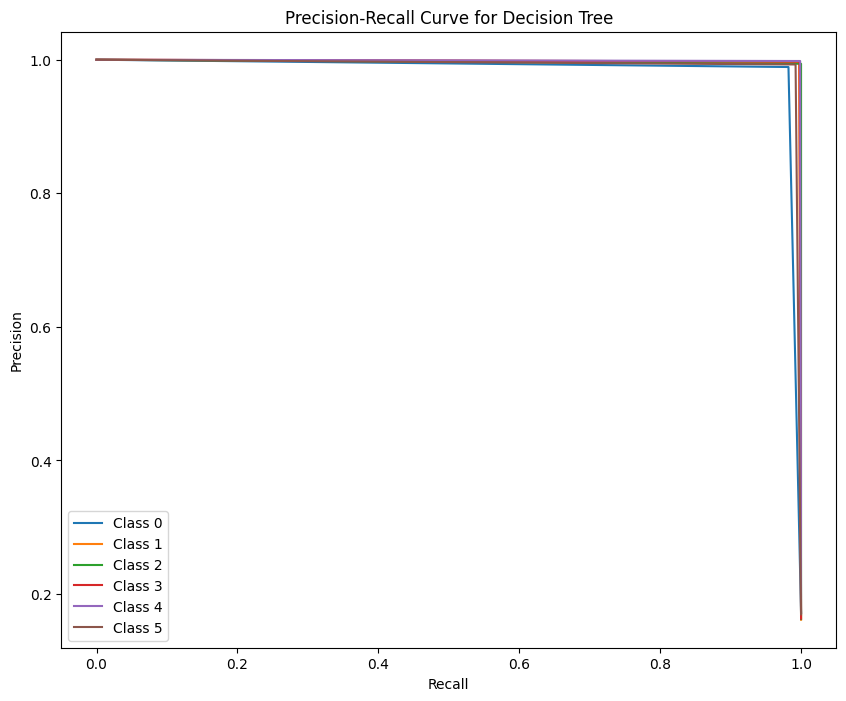

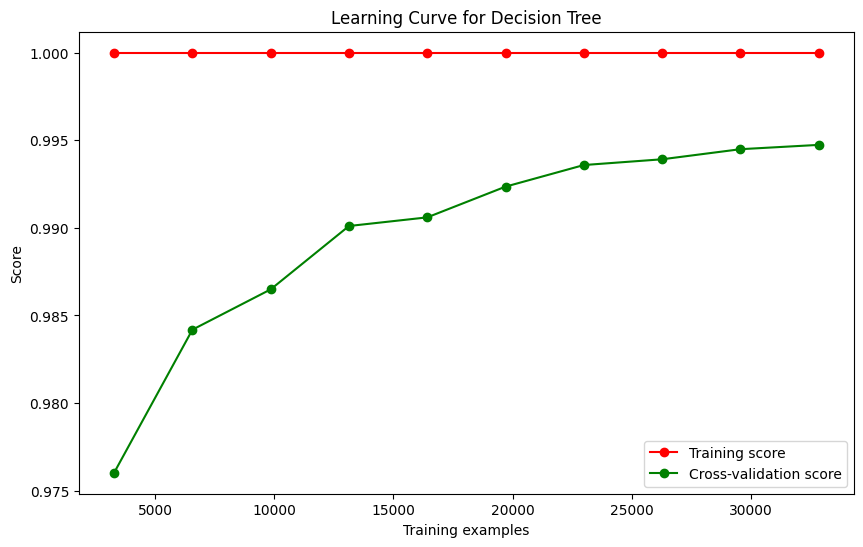

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load data
X_train = pd.read_csv('/content/Predictive_Maintenance/X_training_smote.csv')
y_train = pd.read_csv('/content/Predictive_Maintenance/y_training_smote.csv')

# Combine train features and target
X_train_combined = X_train
y_train_combined = y_train.values.ravel()  # Reshape y_train_combined here

# Split dataset into train and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_train_combined, y_train_combined, test_size=0.2, random_state=42
)

# Define Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Perform 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = []
precision_scores = []
recall_scores = []
f1_scores = []
support_scores = []

for train_index, test_index in tqdm(cv.split(X_train_combined, y_train_combined),
                                     desc="Cross-validation for Decision Tree",
                                     total=cv.get_n_splits()):
    X_train, X_test = X_train_combined.iloc[train_index], X_train_combined.iloc[test_index]
    y_train, y_test = y_train_combined[train_index], y_train_combined[test_index]

    # Train the model
    decision_tree.fit(X_train, y_train)

    # Evaluate the model
    y_pred = decision_tree.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    support_scores.append(support)

# Calculate mean and standard deviation of accuracy
mean_acc = np.mean(scores)
std_acc = np.std(scores)

# Calculate mean precision, recall, f1-score, and support for each class
mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)
mean_support = np.mean(support_scores, axis=0)

print(f"Decision Tree: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")
for i, class_label in enumerate(np.unique(y_train_combined)):
    print(f"Class {class_label}: Precision = {mean_precision[i]:.4f}, Recall = {mean_recall[i]:.4f}, F1-Score = {mean_f1[i]:.4f}, Support = {mean_support[i]:.0f}")

# Train final Decision Tree model on the entire training set
decision_tree.fit(X_train_combined, y_train_combined)
y_pred = decision_tree.predict(X_test_combined)
y_prob = decision_tree.predict_proba(X_test_combined)

# Save the Decision Tree model using joblib
model_filename = '/content/Predictive_Maintenance/decisiontree_model.joblib'
joblib.dump(decision_tree, model_filename)
print(f"Model saved: {model_filename}")

# Confusion Matrix
cm = confusion_matrix(y_test_combined, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    fpr, tpr, _ = roc_curve(y_test_combined == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_train_combined))):
    precision, recall, _ = precision_recall_curve(y_test_combined == i, y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decision Tree')
plt.legend(loc='lower left')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(decision_tree, X_train_combined, y_train_combined, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve for Decision Tree')
plt.legend(loc="best")
plt.show()


In [ ]:
import pandas as pd
import joblib

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample1.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']


# Load the trained logistic regression model
model_filename = '/content/Predictive_Maintenance/logisticregression_model.joblib'
logistic_regression_model = joblib.load(model_filename)

# Make predictions
predictions = logistic_regression_model.predict(new_data.drop(columns=['Failure Type']))

# If probability predictions are needed
probabilities = logistic_regression_model.predict_proba(new_data.drop(columns=['Failure Type']))

# Decode predictions back to original class labels using the encoder
failure_type_encoder = label_encoders['Failure Type']
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_lr.csv', index=False)
print("Predictions saved to predicted_failure_types_lr.csv")


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: No Failure
Sample 5: No Failure
Sample 6: Heat Dissipation Failure
Sample 7: Power Failure
Sample 8: Overstrain Failure
Sample 9: Tool Wear Failure
Sample 10: Random Failures
Predictions saved to predicted_failure_types_lr.csv


In [ ]:
import pandas as pd
import joblib

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample2.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']


# Load the trained logistic regression model
model_filename = '/content/Predictive_Maintenance/logisticregression_model.joblib'
logistic_regression_model = joblib.load(model_filename)

# Make predictions
predictions = logistic_regression_model.predict(new_data.drop(columns=['Failure Type']))

# If probability predictions are needed
probabilities = logistic_regression_model.predict_proba(new_data.drop(columns=['Failure Type']))

# Decode predictions back to original class labels using the encoder
failure_type_encoder = label_encoders['Failure Type']
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_lr_onlyfailure.csv', index=False)
print("Predictions saved to predicted_failure_types_lr_onlyfailure.csv")


Predicted Failure Types:
Sample 1: Heat Dissipation Failure
Sample 2: Heat Dissipation Failure
Sample 3: Power Failure
Sample 4: Power Failure
Sample 5: Overstrain Failure
Sample 6: Overstrain Failure
Sample 7: Random Failures
Sample 8: Random Failures
Sample 9: Tool Wear Failure
Sample 10: Tool Wear Failure
Predictions saved to predicted_failure_types_lr_onlyfailure.csv


In [ ]:
import pandas as pd
import joblib

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample3.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained logistic regression model
model_filename = '/content/Predictive_Maintenance/logisticregression_model.joblib'
logistic_regression_model = joblib.load(model_filename)

# Drop unnecessary columns
columns_to_drop = ['Failure Type', 'Discretized_Target', 'Target']
new_data = new_data.drop(columns=[col for col in columns_to_drop if col in new_data.columns])

# Make predictions
predictions = logistic_regression_model.predict(new_data)

# If probability predictions are needed
probabilities = logistic_regression_model.predict_proba(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_lr_nofailure.csv', index=False)
print("Predictions saved to predicted_failure_types_lr_nofailure.csv")


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: No Failure
Sample 5: No Failure
Sample 6: No Failure
Sample 7: Random Failures
Sample 8: No Failure
Sample 9: No Failure
Sample 10: No Failure
Predictions saved to predicted_failure_types_lr_nofailure.csv


In [ ]:
import pandas as pd
import joblib

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample1.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']


# Load the trained knn model
model_filename = '/content/Predictive_Maintenance/knn_model.joblib'
knn_model = joblib.load(model_filename)

# Make predictions
predictions = knn_model.predict(new_data.drop(columns=['Failure Type']))

# If probability predictions are needed
probabilities = knn_model.predict_proba(new_data.drop(columns=['Failure Type']))

# Decode predictions back to original class labels using the encoder
failure_type_encoder = label_encoders['Failure Type']
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_knn.csv', index=False)
print("Predictions saved to predicted_failure_types_knn.csv")


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: Heat Dissipation Failure
Sample 5: No Failure
Sample 6: Heat Dissipation Failure
Sample 7: Power Failure
Sample 8: Overstrain Failure
Sample 9: Tool Wear Failure
Sample 10: Random Failures
Predictions saved to predicted_failure_types_knn.csv


In [ ]:
import pandas as pd
import joblib

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample2.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']


# Load the trained knn model
model_filename = '/content/Predictive_Maintenance/knn_model.joblib'
knn_model = joblib.load(model_filename)

# Make predictions
predictions = knn_model.predict(new_data.drop(columns=['Failure Type']))

# If probability predictions are needed
probabilities = knn_model.predict_proba(new_data.drop(columns=['Failure Type']))

# Decode predictions back to original class labels using the encoder
failure_type_encoder = label_encoders['Failure Type']
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_knn_onlyfailure.csv', index=False)
print("Predictions saved to predicted_failure_types_knn_onlyfailure.csv")


Predicted Failure Types:
Sample 1: Heat Dissipation Failure
Sample 2: Heat Dissipation Failure
Sample 3: Power Failure
Sample 4: Power Failure
Sample 5: Overstrain Failure
Sample 6: Overstrain Failure
Sample 7: Random Failures
Sample 8: Random Failures
Sample 9: Tool Wear Failure
Sample 10: Tool Wear Failure
Predictions saved to predicted_failure_types_knn_onlyfailure.csv


In [ ]:
import pandas as pd
import joblib

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample3.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained knn model
model_filename = '/content/Predictive_Maintenance/knn_model.joblib'
knn_model = joblib.load(model_filename)

# Drop unnecessary columns
columns_to_drop = ['Failure Type', 'Discretized_Target', 'Target']
new_data = new_data.drop(columns=[col for col in columns_to_drop if col in new_data.columns])

# Make predictions
predictions = knn_model.predict(new_data)

# If probability predictions are needed
probabilities = knn_model.predict_proba(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_knn_nofailure.csv', index=False)
print("Predictions saved to predicted_failure_types_knn_nofailure.csv")


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: Heat Dissipation Failure
Sample 5: No Failure
Sample 6: No Failure
Sample 7: No Failure
Sample 8: No Failure
Sample 9: No Failure
Sample 10: No Failure
Predictions saved to predicted_failure_types_knn_nofailure.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample1.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained SVM model
model_filename = '/content/Predictive_Maintenance/svm_rbf_model.joblib'
svm_rbf_model = joblib.load(model_filename)

# Load the feature names used during training
feature_names_filename = '/content/Predictive_Maintenance/feature_names.joblib'
feature_names = joblib.load(feature_names_filename)

# Ensure the new data has the same feature names as the training data
for feature in feature_names:
    if feature not in new_data.columns:
        new_data[feature] = 0  # Add missing features with default values

# Reorder columns to match the training data
new_data = new_data[feature_names]

# Make predictions
predictions = svm_rbf_model.predict(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions in the desired format
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions, start=1):
    print(f"Sample {i}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_svm.csv', index=False)
print("Predictions saved to predicted_failure_types_svm.csv")


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: No Failure
Sample 5: Random Failures
Sample 6: Heat Dissipation Failure
Sample 7: Power Failure
Sample 8: Overstrain Failure
Sample 9: Tool Wear Failure
Sample 10: Random Failures
Predictions saved to predicted_failure_types_svm.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample2.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained SVM model
model_filename = '/content/Predictive_Maintenance/svm_rbf_model.joblib'
svm_rbf_model = joblib.load(model_filename)

# Make predictions
predictions = svm_rbf_model.predict(new_data.drop(columns=['Failure Type']))

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_svm_onlyfailure.csv', index=False)
print("Predictions saved to predicted_failure_types_svm_onlyfailure.csv")


Predicted Failure Types:
Sample 1: Heat Dissipation Failure
Sample 2: Heat Dissipation Failure
Sample 3: Power Failure
Sample 4: Power Failure
Sample 5: Overstrain Failure
Sample 6: Overstrain Failure
Sample 7: Random Failures
Sample 8: Random Failures
Sample 9: Tool Wear Failure
Sample 10: Tool Wear Failure
Predictions saved to predicted_failure_types_svm_onlyfailure.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample3.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained SVM model
model_filename = '/content/Predictive_Maintenance/svm_rbf_model.joblib'
svm_rbf_model = joblib.load(model_filename)

# Remove unnecessary columns
columns_to_drop = ['Failure Type', 'Discretized_Target', 'Target']
new_data = new_data.drop(columns=[col for col in columns_to_drop if col in new_data.columns])

# Make predictions
predictions = svm_rbf_model.predict(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_svm_nofailure.csv', index=False)
print("Predictions saved to predicted_failure_types_svm_nofailure.csv")


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: No Failure
Sample 5: Random Failures
Sample 6: No Failure
Sample 7: No Failure
Sample 8: No Failure
Sample 9: No Failure
Sample 10: No Failure
Predictions saved to predicted_failure_types_svm_nofailure.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample1.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained Decision Tree model
model_filename = '/content/Predictive_Maintenance/decisiontree_model.joblib'
decision_tree_model = joblib.load(model_filename)

# Ensure the columns in new_data match the feature names used in the model
required_features = decision_tree_model.feature_names_in_

# Ensure the DataFrame has the required features
missing_features = set(required_features) - set(new_data.columns)
if missing_features:
    raise ValueError(f"Missing required features: {missing_features}")

new_data = new_data[required_features]

# Make predictions
predictions = decision_tree_model.predict(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_decision_tree.csv', index=False)
print("Predictions saved to predicted_failure_types_decision_tree.csv")

# Evaluate the model on the new data (if true labels are available)
if 'Failure Type' in new_data.columns:
    true_labels = new_data['Failure Type']
    print("Classification Report:")
    print(classification_report(true_labels, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predictions))


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: No Failure
Sample 5: No Failure
Sample 6: Heat Dissipation Failure
Sample 7: Power Failure
Sample 8: Overstrain Failure
Sample 9: Tool Wear Failure
Sample 10: Random Failures
Predictions saved to predicted_failure_types_decision_tree.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample2.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained Decision Tree model
model_filename = '/content/Predictive_Maintenance/decisiontree_model.joblib'
decision_tree_model = joblib.load(model_filename)

# Ensure the columns in new_data match the feature names used in the model
required_features = decision_tree_model.feature_names_in_

# Ensure the DataFrame has the required features
missing_features = set(required_features) - set(new_data.columns)
if missing_features:
    raise ValueError(f"Missing required features: {missing_features}")

new_data = new_data[required_features]

# Make predictions
predictions = decision_tree_model.predict(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_decision_tree_onlyfailure.csv', index=False)
print("Predictions saved to predicted_failure_types_decision_tree_onlyfailure.csv")

# Evaluate the model on the new data (if true labels are available)
if 'Failure Type' in new_data.columns:
    true_labels = new_data['Failure Type']
    print("Classification Report:")
    print(classification_report(true_labels, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predictions))


Predicted Failure Types:
Sample 1: Heat Dissipation Failure
Sample 2: Heat Dissipation Failure
Sample 3: Power Failure
Sample 4: Power Failure
Sample 5: Overstrain Failure
Sample 6: Overstrain Failure
Sample 7: Random Failures
Sample 8: Random Failures
Sample 9: Tool Wear Failure
Sample 10: Tool Wear Failure
Predictions saved to predicted_failure_types_decision_tree_onlyfailure.csv


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed data for prediction
new_data = pd.read_csv('/content/Predictive_Maintenance/sample3.csv')

# Load label encoders
label_encoders_filename = '/content/Predictive_Maintenance/label_encoders.joblib'
label_encoders = joblib.load(label_encoders_filename)

# Access the Failure Type encoder
failure_type_encoder = label_encoders['Failure Type']

# Load the trained Decision Tree model
model_filename = '/content/Predictive_Maintenance/decisiontree_model.joblib'
decision_tree_model = joblib.load(model_filename)

# Ensure the columns in new_data match the feature names used in the model
required_features = decision_tree_model.feature_names_in_

# Ensure the DataFrame has the required features
missing_features = set(required_features) - set(new_data.columns)
if missing_features:
    raise ValueError(f"Missing required features: {missing_features}")

new_data = new_data[required_features]

# Make predictions
predictions = decision_tree_model.predict(new_data)

# Decode predictions back to original class labels using the encoder
decoded_predictions = failure_type_encoder.inverse_transform(predictions)

# Display predictions
print("Predicted Failure Types:")
for i, prediction in enumerate(decoded_predictions):
    print(f"Sample {i+1}: {prediction}")

# Save predictions to a CSV file
new_data['Predicted Failure Type'] = decoded_predictions
new_data.to_csv('/content/Predictive_Maintenance/predicted_failure_types_decision_tree_nofailure.csv', index=False)
print("Predictions saved to predicted_failure_types_decision_tree_nofailure.csv")

# Evaluate the model on the new data (if true labels are available)
if 'Failure Type' in new_data.columns:
    true_labels = new_data['Failure Type']
    print("Classification Report:")
    print(classification_report(true_labels, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predictions))


Predicted Failure Types:
Sample 1: No Failure
Sample 2: No Failure
Sample 3: No Failure
Sample 4: No Failure
Sample 5: No Failure
Sample 6: No Failure
Sample 7: No Failure
Sample 8: No Failure
Sample 9: No Failure
Sample 10: No Failure
Predictions saved to predicted_failure_types_decision_tree_nofailure.csv
